# Anya's Prospector Tutorial 

I've set up this tutorial to first break down the parameter file, then show how we analyze the results after we run the code.

## Getting Everything Installed Correctly
If you have access to the projects/p30555 folder then simply do: conda activate /projects/p30555/modules/prospector.

If you do not have access to this, or want to create your own Prospector environment follow these instructions:

1. Create a conda environment with Python 2.7.
2. Install numpy, scipy, matplotlib, corner, h5py, astropy, pyfits, dynesty, emcee, and prospect. (some of these you will be able to use conda install, and some may require git clone)
3. Get FSPS (note: this is the fortran version, not python!)
    
    a. Use this command: git clone https://github.com/cconroy20/fsps
    
    b. Then, we need to edit the "Makefile" in the src directory (cd src; emacs Makefile)
    
    c. Within the Makefile: make sure the F90 = gfortran line is uncommented.
    
    d. Within the Makefile: comment the F90FLAGS = -O -cpp line and uncomment F90FLAGS = -O3 -march=native -cpp
    
    e. Add -fPIC to the line you just uncommented so that it reads: F90FLAGS = -O3 -march=native -cpp -fPIC
    
    f. Save the Makefile then use these commands: make clean; make all

4. Now we need python-fsps!
    
    a. Use this command (might be useful to have this in your .bashrc or activated with your environment): export SPS_HOME=$HOME/fsps
    
    b. Now, you can pip install fsps or grab python-fsps's git to install

5. It should work now, but try using running all the commands in this jupyter notebook and running the lines:
        python prospector_dynesty.py --param_file=name_of_param_file.py
        
   
   (NOTE: you will have to have parameter file for this to work -- so create one/grab the one from the Example folder)

    


## Breaking Down the Parameter File

There are several key functions within the parameter file that we can change depending on our scientific interests: 
1. <font color=green>run_params</font> dictionary 
2. <font color=green>load_obs( )</font> function - or, photometry and spectroscopy of galaxy 
3. <font color=green>load_model( )</font> function - where we build the model for the galaxy 

Let's start with all the packages we need to load into the parameter file:
- You won't need matplotlib, I just added it in so we could visualize what Prospector does.
- Basically everything should be in numpy arrays, which is why we need numpy.
- We need to load in all the functions the build the model.
- SedPy is great for using the filter transmission curves.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np 
from prospect.models import priors, SedModel 
from prospect.models.templates import TemplateLibrary
from prospect.sources import CSPSpecBasis
from sedpy.observate import load_filters

## (1) run_params Dictionary

The run_params dictionary is where we save all important function calls for Dynesty, output file names, and some function calls for the observational data and model. The function calls for Dynesty should remain as I have listed (this is also what Joel has put on his Prospector tutorial online). However, if you are really interested in nested sampling and MCMC, you can check out this link: https://dynesty.readthedocs.io/en/latest/dynamic.html#dynamic-nested-sampling.

In [2]:
run_params = {# Prospector Outputs 
              'verbose':True,
              'debug':False,
              'outfile':'LGRB_140713a',
              'output_pickles': False,
              # Optimization parameters
              'do_powell': False,
              'ftol':3e-16, 'maxfev': 5000,
              'do_levenburg': True,
              'nmin': 5,
              # dynesty Fitter parameters
              'nested_bound': 'multi', # bounding method
              'nested_sample': 'unif', # sampling method
              'nested_nlive_init': 100,
              'nested_nlive_batch': 100,
              'nested_bootstrap': 0,
              'nested_dlogz_init': 0.05,
              'nested_weight_kwargs': {"pfrac": 1.0},
              'nested_stop_kwargs': {"post_thresh": 0.1},
              # Obs data parameters
              'objid':140713,
              'logify_spectrum':False,
              'normalize_spectrum':False,
              'luminosity_distance': None,  # in Mpc
              # Model parameters - I EXPLAIN THESE LATER!
              'add_neb': True,
              'add_dust': False,
              # SPS parameters
              'zcontinuous': 1,
              }

## (2) load_obs( ) function

The next thing is to make the load_obs( ) function, which is where we input all the observational data we have. This basically works by building an obs dictionary within the function.

### Basics
Here is what the obs dictionary should ALWAYS contain:
- <font color=green>obs["phot_wave"]</font> = numpy array of the wavelengths in Angstroms from the photometry
- <font color=green>obs["maggies"]</font> = numpy array of fluxes in maggies from photometry
- <font color=green>obs["maggies_unc"]</font> = numpy array of flux uncertainties in maggies from photometry
- <font color=green>obs["wavelength"]</font> = numpy array of wavelengths in Angstroms from spectra
- <font color=green>obs["spectrum"]</font> = numpy array of flux densities from spectra (should be flux density/Hz)
- <font color=green>obs["unc"]</font> = numpy array of flux density uncertainties from spectra (should be flux density/Hz)

Most of the time, our photometry is in terms of apparent magnitude ($M_{AB}$) instead of flux density in maggies. Use this conversion:
\begin{equation}
f = 10^{-0.4*M_{AB}}.
\end{equation}

### SedPy Practice
Now, let's look at how to easily get the wavelengths from the photometry into the obs dictionary using SedPy. The first thing to check is if SedPy has telescope filters we want. 

In [3]:
from sedpy.observate import list_available_filters

list_available_filters()

['sdss_i0',
 'acs_wfc_f555w',
 'jwst_f444w',
 'jwst_f2550w',
 'twomass_Ks',
 'wise_w3',
 'herschel_spire_ext_500',
 'uvot_w1',
 'jwst_f1800w',
 'twomass_H',
 'acs_wfc_f606w',
 'jwst_f200w',
 'bessell_V',
 'wfc3_uvis_f475w',
 'wfc3_ir_f110w',
 'wfc3_uvis_f606w',
 'herschel_spire_250',
 'herschel_pacs_70',
 'bessell_U',
 'jwst_f1280w',
 'jwst_f460m',
 'jwst_f430m',
 'wise_w4',
 'hipparcos_B',
 'gaia_bp',
 'acs_wfc_f435w',
 'jwst_f356w',
 'jwst_f1000w',
 'spitzer_irac_ch4',
 'spitzer_irs_16',
 'jwst_f300m',
 'jwst_f770w',
 'acs_wfc_f814w',
 'jwst_f140m',
 'herschel_spire_ext_250',
 'hsc_i',
 'acs_wfc_f625w',
 'wfc3_uvis_f336w',
 'herschel_spire_350',
 'jwst_f182m',
 'jwst_f210m',
 'bessell_B',
 'galex_NUV',
 'wfc3_ir_f140w',
 'hsc_y',
 'spitzer_irac_ch2',
 'jwst_f277w',
 'wfc3_uvis_f275w',
 'wise_w2',
 'jwst_f1500w',
 'gaia_rp',
 'stromgren_b',
 'spitzer_mips_70',
 'jwst_f560w',
 'stromgren_u',
 'jwst_f410m',
 'wfc3_uvis_f555w',
 'hsc_r',
 'jwst_f2100w',
 'spitzer_irac_ch3',
 'herschel_pa

That's a lot of filters! SedPy has a majority of the filters/bands we could be interested in and already has all the filter transmission curves we need to find the wavelengths for our photometric points. If you already know what the wavelengths should be for the each of your filters, go ahead and put them in as a NumPy array in obs["phot_wave"]. If you do not know what the filter wavelength is and do not see the telescope/filter you used above and want to use SedPy, follow these instructions: https://github.com/bd-j/sedpy/blob/master/docs/faq.rst. You'll basically just create a 2 column ASCII file with the first column being the wavelengths in Angstroms and the second column being the percent transmission, then put those files into the SedPy "Filters" folder.

We'll assume for this tutorial that our filters are listed above. LGRB 140713a has photometric points in griz and JK bands, so we'll use SedPy's SDSS filters for griz and the 2MASS filters for J and K.  

In [4]:
# Make an obs dictionary
obs = {}

# First, make a list of the filters you want and set them equal to "filternames"
sdss = ['sdss_{0}0'.format(b) for b in ['g', 'r', 'i', 'z']]
twomass = ['twomass_J', 'twomass_Ks']

filternames = sdss + twomass

# Load in the filter transmission curves using SedPy's load_filter() function
obs["filters"] = load_filters(filternames)

# Find the wavelengths using .wave_effective from SedPy
obs["phot_wave"] = [f.wave_effective for f in obs["filters"]]

# Put in photometry magnitude points (**NOTE: NEEDS TO BE IN SAME ORDER AS FILTERS)
M_AB = np.array([24.124, 23.854, 22.645, 22.357, 21.946,  22.773])
M_AB_unc = np.array([0.0914, 0.1898, 0.0858, 0.1188, 0.156, 0.180])

# Convert to flux in maggies
mags = 10**(-0.4*M_AB)

# Convert magnitude uncertainties to flux uncertainties
mag_down = [x-y for (x,y) in zip(M_AB, M_AB_unc)]
flux_down = [10**(-0.4*x) for x in mag_down]
flux_uncertainty = [y-x for (x,y) in zip(mags, flux_down)]

obs['maggies'] = np.array(mags)
obs['maggies_unc'] = np.array(flux_uncertainty)

# Here we mask out any NaNs or infs
obs['phot_mask'] = np.isfinite(np.squeeze(mags))

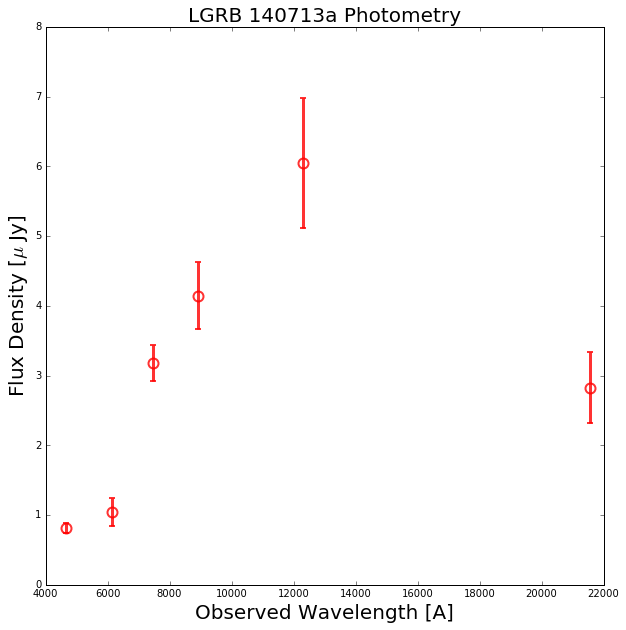

In [5]:
# Now let's plot the photometry just to see if it looks right:
plt.figure(figsize=(10,10))
plt.errorbar(obs["phot_wave"], obs['maggies']*3631*1e6, yerr=obs['maggies_unc']*3631*1e6, 
         label='Observed photometry', ecolor='red', 
         marker='o', markersize=10, ls='', lw=3, alpha=0.8, 
         markerfacecolor='none', markeredgecolor='red', 
         markeredgewidth=2)
plt.xlabel('Observed Wavelength [A]',fontsize =20)
plt.ylabel(r'Flux Density [$\mu$ Jy]',fontsize =20)
plt.title('LGRB 140713a Photometry',fontsize =20)
plt.ylim(0, 8)
plt.show()

Ok that seems good! In this example, we're not imputting any spectra. Therefore set:
- obs["wavelength"] = None
- obs["spectrum"] = None.

Now, the whole load_obs function should look like this:

In [6]:
def load_obs(objid=run_params["objid"], phottable=None,
             luminosity_distance=0, snr=10, **kwargs):
    # Build output dictionary.
    obs = {}
    # First, make a list of the filters you want and set them equal to "filternames"
    sdss = ['sdss_{0}0'.format(b) for b in ['g', 'r', 'i', 'z']]
    twomass = ['twomass_J', 'twomass_Ks']

    filternames = sdss + twomass

    # Load in the filter transmission curves using SedPy's load_filter() function
    obs["filters"] = load_filters(filternames)

    # Find the wavelengths using .wave_effective from SedPy
    obs["phot_wave"] = [f.wave_effective for f in obs["filters"]]

    # Put in photometry magnitude points (**NOTE: NEEDS TO BE IN SAME ORDER AS FILTERS)
    M_AB = np.array([24.124, 23.854, 22.645, 22.357, 21.946,  22.773])
    M_AB_unc = np.array([0.0914, 0.1898, 0.0858, 0.1188, 0.156, 0.180])

    # Convert to flux in maggies
    mags = 10**(-0.4*M_AB)

    # Convert magnitude uncertainties to flux uncertainties
    mag_down = [x-y for (x,y) in zip(M_AB, M_AB_unc)]
    flux_down = [10**(-0.4*x) for x in mag_down]
    flux_uncertainty = [y-x for (x,y) in zip(mags, flux_down)]

    obs['maggies'] = np.array(mags)
    obs['maggies_unc'] = np.array(flux_uncertainty)

    # Here we mask out any NaNs or infs
    obs['phot_mask'] = np.isfinite(np.squeeze(mags))
    
    # No spectrum
    obs['wavelength'] = None
    obs['spectrum'] = None
    obs['unc'] = None
    
    obs['objid'] = objid

    return obs

## (3) load_model( ) function

The next most important thing is building the model, which we do in the load_model( ) function. This model is constructed using functions in Python FSPS, a stellar population synthesis code (see more: http://dfm.io/python-fsps/current/stellarpop_api/). 

The models are loaded in through a Prospector template, which we change slightly for our data. We use the "parametric_sfh" (star formation history) template, as using a parametric model and is the most simple. There is also a non-parametric option in Prospector, but this is much more complicated.

This template looks like:

In [7]:
TemplateLibrary.describe('parametric_sfh')

Free Parameters: (name: prior) 
-----------
  logzsol: <class 'prospect.models.priors.TopHat'>(mini=-2,maxi=0.19)
  dust2: <class 'prospect.models.priors.TopHat'>(mini=0.0,maxi=2.0)
  tau: <class 'prospect.models.priors.LogUniform'>(mini=0.1,maxi=30)
  tage: <class 'prospect.models.priors.TopHat'>(mini=0.001,maxi=13.8)
  mass: <class 'prospect.models.priors.LogUniform'>(mini=100000000.0,maxi=1e+12)

Fixed Parameters: (name: value [, depends_on]) 
-----------
  imf_type: 2 
  dust_type: 0 
  zred: 0.1 
  sfh: 4 


Before getting to the parameters we are interested in, we need to set the initial mass function (IMF), star formation history (SFH), and dust attenuation. All the different functions are assigned numbers in Python-FSPS, which you can look into more in the link above, but I will also give them here. The functions that are highlighted are the ones which I typically use.

IMF:
- (0) Salpeter
- <font color=green>(1) Chabrier</font>
- (2) Kroupa
- (3) van Dokkum
- (4) Dave (2008)
- (5) Tabulate piece-wise, power-law IMF


SFH:
- (0) Compute a simple stellar population (SSP)
- (1) Tau-model
- (2) Not an option
- (3) Setting your own SFH (different SFHs for different ages of galaxy)
- <font color=green>(4) Delayed-tau model ($t*e^{-t/\tau}$)</font>
- (5) Delayed-tau model with a time sf_trunc that lead to linearly decreasing SFH

Dust Attenuation:
- (0) Power Law
- <font color=green>(1) Milky Way Dust Extinction Law</font>
- (2) Calzetti et. al. Attenuation Curve 
- (3) A handful of attenuation curves from Witt and Gordon
- (4) Kriek and Conroy Attenuation Curve


Let's get to the parameters now! Prospector allows us to have both free and fixed parameters. The "free" parameters are sent to the MCMC to be iterated over to find the most probable value. The "fixed" parameters are typically parameters that we know the value of - most of the time, this is redshift. The parameters we are most interested in are: age, mass, metallicity, redshift, and dust extinction, and the $\tau$ parameter for the delayed-tau SFH model.

Here are the units for these parameters and how you call them in Prospector:
- Age (called "tage") [Gyr], ranges from 0.0 to 13.8 Gyr
- Mass (called "mass") [M$_\odot$]
- Dust extinction (called "dust2"), in magnitudes, default = 0.0
- Metallicity (called "logzsol"), given by log(Z/Z$_\odot$), where Z is the metallicity, "logzsol" ranges from -1.5 to 0.2
- Tau (called "tau"), ranges from 0.1 to 100, default = 1.0
- Redshift (called "zred"), this is a fixed value in the parameter file with default z = 0.1

We set the parameters as follows:

In [8]:
# Load in the parametric_SFH template dictionary:
model_params = TemplateLibrary["parametric_sfh"]

# Set the fixed values
model_params["imf_type"]["init"] = 1 # Chabrier
model_params["dust_type"]["init"] = 1 # Milky Way extinction law
model_params["sfh"]["init"] = 4 # non delayed-tau 

# Set values as free or fixed and if fixed, give them an assigned value
# Note: in this template, almost all of these are free parameters, so its up to you to fix them if needed
model_params["logzsol"]["isfree"] = False
model_params["logzsol"]["init"] =  0.0 # solar metallicity 

model_params["tau"]["isfree"] = True
model_params["dust2"]["isfree"] = True
model_params["mass"]["isfree"] = True
model_params["tage"]["isfree"] = True
model_params["zred"]['isfree'] = True

For the free parameters, we can also create a range values over which the MCMC walks. Its best to constrain these values such that you can get a nice-looking histogram in the plots, and such that the code runs most efficiently (quickly). However, you probably won't know what these ranges should be with your first run. 

I do recommend that if you have the redshift, you go to http://www.astro.ucla.edu/~wright/CosmoCalc.html and find the age of the universe at that redshift and set that value as the maximum "tage" value. What's also important to note is that the MCMC walkers do not know that the age of the universe is 13.8 Gyr or that a logzsol value of 1.0 is completely unrealistic! Make sure you choose your ranges such that the values are all within reason. I give examples below:

In [9]:
# adjust priors
model_params["tau"]["prior"] = priors.LogUniform(mini=0.1, maxi=10)
model_params["mass"]["prior"] = priors.LogUniform(mini=1e6, maxi=1e12)
model_params["tage"]["prior"] = priors.TopHat(mini=0.0, maxi=13.8)
model_params["logzsol"]["prior"] = priors.TopHat(mini=-1.5,maxi=0.2)
model_params["dust2"]["prior"] = priors.TopHat(mini=-0.1,maxi=2.0)

As great as it would be to have all of these values set as "free" parameters in our model, it is unfortunately inefficient. Remember that the more parameters you set as "free", the bigger the parameter space is in the MCMC and the longer the code will run. Sometimes, its best to have some of these parameters fixed, especially if we have an inkling about what they should be centered on. For example, most early-type/elliptical galaxies have very low dust (magnitude value ~0), so if we are working with this kind of galaxy, we can set the dust2 = 0.0! Another large problem I have found with Prospector is that the age-metallicity-dust degeneracy is quite significant and having metallicity be a free parameter is sometimes not possible (MCMC gets stuck in probability whole), so I typically set this to solar. However - it might also be in your best scientific interest to keep metallicity fixed, but do several Prospector runs with different metallicities, especially if metallicity is an important factor in your galaxy modeling!


The whole load_model( ) function looks like this:

In [18]:
def load_model(object_redshift=None, add_dust=False,
               add_neb=True, luminosity_distance=None, **extras):
    model_params = TemplateLibrary["parametric_sfh"]

    #fixed values
    model_params["imf_type"]["init"] = 1 # Chabrier
    model_params["dust_type"]["init"] = 1 # Milky Way extinction law
    model_params["sfh"]["init"] = 4 # non delayed-tau 
    model_params["logzsol"]["isfree"] = False
    model_params["logzsol"]["init"] =  0.0 
    
    #model_params["zred"]["isfree"] = True

    # adjust priors
    model_params["tau"]["prior"] = priors.LogUniform(mini=0.1, maxi=10)
    model_params["mass"]["prior"] = priors.LogUniform(mini=1e6, maxi=1e12)
    model_params["tage"]["prior"] = priors.TopHat(mini=0.0, maxi=13.8)
    #model_params["logzsol"]["prior"] = priors.TopHat(mini=-1.5,maxi=0.2)
    model_params["dust2"]["prior"] = priors.TopHat(mini=-0.1,maxi=2.0)
    #model_params["zred"]["prior"] = priors.TopHat(mini=0.1,maxi=5.0)
    
    # Setting redshift if we have it
    if object_redshift is not None:
        model_params["zred"]['isfree'] = False
        model_params["zred"]['init'] = object_redshift

    # Add nebular emission parameters and turn nebular emission on
    if add_neb:
        model_params.update(TemplateLibrary["nebular"])  

    # Now instantiate the model using this new dictionary of parameter specifications
    model = SedModel(model_params)

    return model

You'll not that there are several other parameters that appeared in the run_params dictinary for the model: add_neb and add_dust. I have add_neb = True as I want the model spectrum to contain the details of the nebular emission. This option will make Prospector run slower, but it does give better results.


## Other Important Functions/ Running the Code
Other functions you will need (and should NOT change) are:

In [11]:
# SPS Object
def load_sps(zcontinuous=1, compute_vega_mags=False, **extras):
    sps = CSPSpecBasis(zcontinuous=zcontinuous,
                       compute_vega_mags=compute_vega_mags)
    return sps

# Gaussian Process
def load_gp(**extras):
    return None, None

Now, you have your whole parameter file! See the example (param_example.py) I put in our Project folder for a clean/ non-Jupyter notebook version.

The next step is to run the code. In the Quest terminal call:
>>> conda activate /projects/p30555/modules/prospector

>>> python prospector_dynesty.py --param-file=name_of_parameter_file.py


You can also create a jobscript, which should look like:

#!/bin/bash
#SBATCH -A p30555
#SBATCH -p long
#SBATCH -t 8:00:00
#SBATCH -n 30
#SBATCH --job-name="prospect_GRB_name"

$\#$ load modules

module load python/2.7.5

module load git

$\#$ activate prospector environment

conda activate /projects/p30555/modules/prospector

$\#$ path needed

export SPS_HOME=$HOME/fsps

echo SPS_HOME

$\#$ command to execute

python prospector_dynesty.py --param-file=name_of_parameter_file.py

Then you can run in your Quest terminal:
>>> conda activate /projects/p30555/modules/prospector

>>> sbatch jobscript_name.sh


Prospector typically takes around 30 min to 2 hours to converge and about 2000 iterations in the MCMC. Your code log (slurm_num.out) should contain something that looks like this:

iter: 1 | batch: 0 | nc: 1 | ncall: 1 | eff(%):  0.990 | logz: -55994850.417 +/-  0.229 | dlogz:    in

iter: 2 | batch: 0 | nc: 1 | ncall: 2 | eff(%):  1.961 | logz: -1130485.445 +/-  0.230 | dlogz:    inf

iter: 3 | batch: 0 | nc: 1 | ncall: 3 | eff(%):  2.913 | logz: -339110.154 +/-  0.230 | dlogz:    inf 

iter: 4 | batch: 0 | nc: 1 | ncall: 4 | eff(%):  3.846 | logz: -215855.564 +/-  0.230 | dlogz: 345576.

iter: 5 | batch: 0 | nc: 1 | ncall: 5 | eff(%):  4.762 | logz: -75645.956 +/-  0.231 | dlogz: 222321.8

iter: 6 | batch: 0 | nc: 1 | ncall: 6 | eff(%):  5.660 | logz: -66334.506 +/-  0.231 | dlogz: 82112.18

iter: 7 | batch: 0 | nc: 1 | ncall: 7 | eff(%):  6.542 | logz: -34836.989 +/-  0.231 | dlogz: 72800.72

iter: 8 | batch: 0 | nc: 2 | ncall: 9 | eff(%):  7.339 | logz: -12861.013 +/-  0.231 | dlogz: 41303.19

iter: 9 | batch: 0 | nc: 1 | ncall: 10 | eff(%):  8.182 | logz: -10112.327 +/-  0.232 | dlogz: 19327.2

iter: 10 | batch: 0 | nc: 1 | ncall: 11 | eff(%):  9.009 | logz: -9580.172 +/-  0.232 | dlogz: 16578.5

...

## Modeling the Fit

Woo! You did it and now you have an output file that has your converged values from the MCMC run. This file should ne named "output_filename_mcmc.h5". Now, we have to analyze this file. We will do this by creating a trace plot, corner plot, and SED of the observed photometry along with the model photometry and model spectroscopy.

First, lets load in all the packages we need:

In [12]:
%matplotlib inline
import sedpy
import prospect
import numpy as np
from prospect.models import priors
from prospect.models.sedmodel import SedModel
import time
import scipy
from matplotlib.pyplot import *
import h5py
import corner as triangle

from prospect.models.templates import TemplateLibrary
from prospect.io.read_results import results_from, get_sps
from prospect.io.read_results import traceplot, subcorner

We will also need to load in the file as well as creating a new run_params dictionary.

In [13]:
run_params = {}
res, obs, mod = results_from('LGRB_140713a_mcmc.h5', dangerous=False)

# let's look at what's stored in the `res` dictionary
print(res.keys())

[u'logvol', u'theta_labels', u'niter', u'model_params', u'samples_id', u'logz', u'ncall', u'efficiency', u'lnprobability', 'model', u'information', u'prospector_version', u'chain', u'lnlikelihood', u'optimizer_duration', u'sampling_duration', 'optimization_results', u'weights', u'run_params', u'logzerr', u'paramfile_text', 'obs']


### Trace Plots

These plots show how the walkers moved over the parameter space per iteration. They should look like they have converged to a value for this to be a "good" fit.

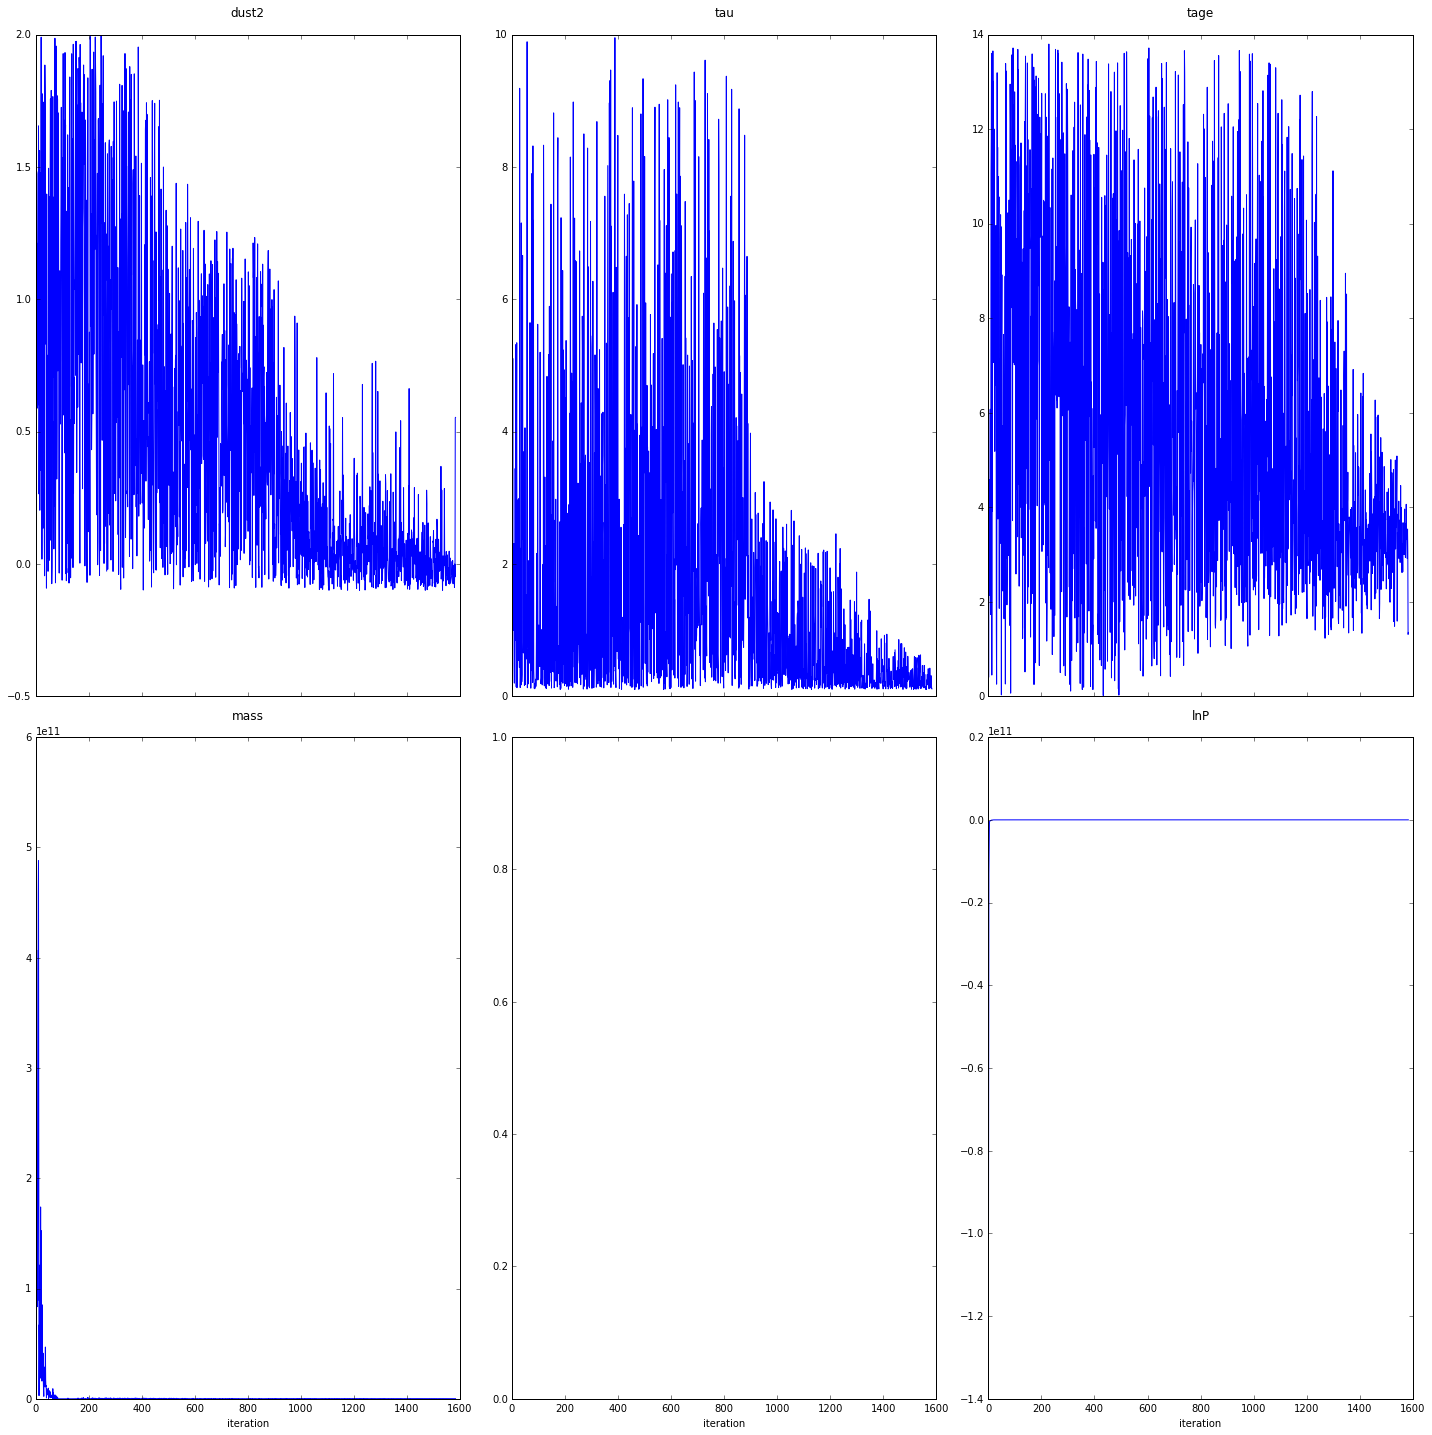

In [14]:
tracefig = traceplot(res, figsize=(20,20))

These plots look _.

Now let's look at the corner plots to see how good the histrograms are and the $1\sigma$ uncertainties for all the free parameters.

## Corner Plots

/home/anm9226/.local/lib/python2.7/site-packages/numpy/ma/core.py:6447: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/home/anm9226/.local/lib/python2.7/site-packages/numpy/ma/core.py:6447: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


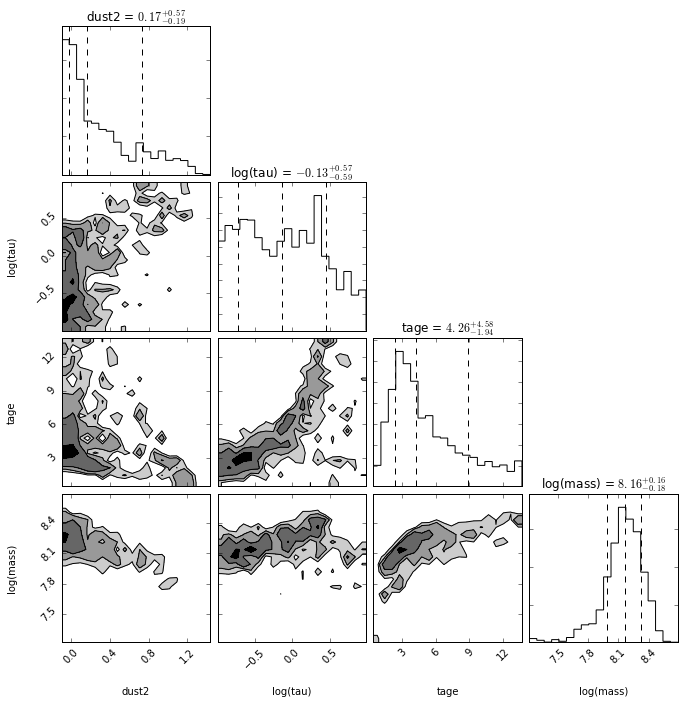

In [15]:
imax = np.argmax(res['lnprobability'])

# The theta_max values give the most probable vales
theta_max = res['chain'][imax, :].copy()

# We start our corner plots 500 iterations in, as the iterations before this usually have nonsensical/ low 
# probability values
cornerfig = subcorner(res, start=500, thin=1,
                      fig=subplots(4,4,figsize=(10,10))[0], fontsize=100)

plt.show()

## SED

Now lets create the SED to see how well our observed data fits to the model. We first need to copy the load_model( ) and load_sps( ) functions in the parameter file. Since those are already in this notebook, I'm not going to copy them again. 

Then call the functions:

In [19]:
mod = load_model(**run_params)
sps = load_sps(**run_params)

Now, we want to build the model spectrum and photometry from the median values or the converged values that we see in the corner plots. We do this by calling the function "quantile" in Prospector and using the 50th percentile values, which re the converged values. We can take a look at how we do this below:

In [20]:
flatchain = res['chain']

from prospect.utils.plotting import quantile
post_pcts = [quantile(flatchain[:, i], percents=50, weights=res.get("weights", None))
             for i in range(mod.ndim)]

# These should have all the converged values
print(post_pcts)

mspec_conv, mphot_conv, _ = mod.mean_model(post_pcts, obs, sps=sps)
print(mphot_conv)

[0.16403167525797518, 0.7392500852528114, 4.260526317555371, 145874562.1580903]
[2.76824611e-10 5.04657841e-10 6.68778322e-10 8.76421686e-10
 1.17562391e-09 1.24231036e-09]


Now, we can plot all of these values!

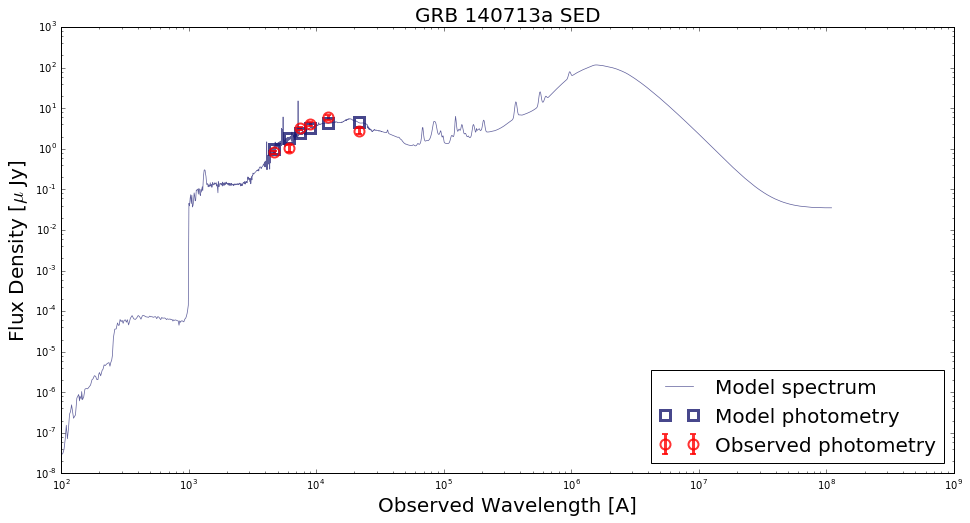

In [19]:
# photometric effective wavelengths
wphot = obs["phot_wave"]

a = 1 + mod.params.get('zred') 

# Spectroscopic wavelengths
if obs["wavelength"] is None:
    # *restframe* spectral wavelengths, since obs["wavelength"] is None
    wspec = sps.wavelengths.copy()
    wspec *= a #redshift them
else:
    wspec = obs["wavelength"]


maggies = obs['maggies']
mags_unc = obs['maggies_unc']

# Make plot of data and model
plt.figure(figsize=(16,8))

plt.loglog(wspec, mspec_conv*3631*1e6, label='Model spectrum',
       lw=0.7, color='midnightblue', alpha=0.7)
plt.errorbar(wphot, mphot_conv*3631*1e6, label='Model photometry',
         marker='s', markersize=10, alpha=0.8, ls='', lw=3, 
         markerfacecolor='none', markeredgecolor='midnightblue', markeredgewidth=3)
plt.errorbar(wphot, obs['maggies']*3631*1e6, yerr=obs['maggies_unc']*3631*1e6, 
         label='Observed photometry', ecolor='red', 
         marker='o', markersize=10, ls='', lw=3, alpha=0.8, 
         markerfacecolor='none', markeredgecolor='red', 
         markeredgewidth=2)
    



plt.xlabel('Observed Wavelength [A]',fontsize =20)
plt.ylabel(r'Flux Density [$\mu$ Jy]',fontsize =20)
plt.title('GRB 140713a SED',fontsize =20)

plt.legend(loc='best', fontsize=20)

plt.show()

We want to see that the model matches the observed photometry well - all the values should line up closely. One important thing to keep in mind is that the infrared photometric points (namely J, K, and H bands) determine stellar mass. Therefore, if the observed and model infrared points are off, we know that Prospector's mass estimate was not super accurate.